# **Sentiment Analysis for Mental Health**

### **Importing Dependencies**

In [1]:
# Print all the outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message=".*no associated frequency information.*")
warnings.filterwarnings("ignore", message=".*Maximum Likelihood optimization failed to converge.*")

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplot
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### **Dataset Setup**

**Step 1: Setting the Directory**

In [2]:
# Base Directory
base_dir = '/Users/reemikadas/Desktop/SCU MSBA/Github/Data_Science/NLP_Projects/NLP | Sentiment Analysis for Mental Health'

# Data Directory
data_dir = os.path.join(base_dir, 'Data')
data_csv_path = os.path.join(data_dir, 'sentiment_health_cleaned.csv')

**Step 2: Loading and Reading the Datasets**

In [3]:
# Loading the DataFrame
df = pd.read_csv(data_csv_path)

# Glimpse of the first 5 rows
df.head()

,unique_id,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


### **Text Preprocessing**

**Example**

----------------------------------------------------------------------------

In [4]:
# Text sample
text = df['statement'].values[2]
text

'All wrong, back off dear, forward doubt. Stay in a restless and restless place'

In [5]:
# Lowercase the sentence
text = text.lower()
text

'all wrong, back off dear, forward doubt. stay in a restless and restless place'

In [6]:
# Remove URLs (if any)
text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
text

'all wrong, back off dear, forward doubt. stay in a restless and restless place'

In [7]:
# Remove Special characters and numbers
text = re.sub(r'[^a-z\s]', '', text)
text

'all wrong back off dear forward doubt stay in a restless and restless place'

In [8]:
# Remove Whitespace
text = re.sub(r'\s+', ' ', text).strip()
text

'all wrong back off dear forward doubt stay in a restless and restless place'

In [9]:
# Stopwords
stop_words = set(stopwords.words('english'))

In [10]:
# Remove Stopwords
text = ' '.join([w for w in text.split() if w not in stop_words])
text

'wrong back dear forward doubt stay restless restless place'

---------------------------------------------------------------------------------------------------------------

Define function to apply text preprocessing on whole datasets.

In [11]:
# Text Preprocessing function

def text_preprocess(text):
    # Lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

In [12]:
df['clean_text'] = df['statement'].apply(text_preprocess)

# Glimpse of the data
df.head(10)

,unique_id,statement,status,clean_text
0,0,oh my gosh,Anxiety,oh gosh
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety,trouble sleeping confused mind restless heart ...
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,wrong back dear forward doubt stay restless re...
3,3,I've shifted my focus to something else but I'...,Anxiety,ive shifted focus something else im still worried
4,4,"I'm restless and restless, it's been a month n...",Anxiety,im restless restless month boy mean
5,5,"every break, you must be nervous, like somethi...",Anxiety,every break must nervous like something wrong ...
6,6,"I feel scared, anxious, what can I do? And may...",Anxiety,feel scared anxious may family us protected
7,7,Have you ever felt nervous but didn't know why?,Anxiety,ever felt nervous didnt know
8,8,"I haven't slept well for 2 days, it's like I'm...",Anxiety,havent slept well days like im restless huh
9,9,"I'm really worried, I want to cry.",Anxiety,im really worried want cry


In [13]:
# Convert the Sentiment Status text to numbers --> eg: 'Anxiety:0', 'Bipolar:1', etc.
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['status'])

# check mapping
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_map)

{'Anxiety': np.int64(0), 'Bipolar': np.int64(1), 'Depression': np.int64(2), 'Normal': np.int64(3), 'Personality disorder': np.int64(4), 'Stress': np.int64(5), 'Suicidal': np.int64(6)}


In [14]:
# Glimpse of the data
df.head()

,unique_id,statement,status,clean_text,label_encoded
0,0,oh my gosh,Anxiety,oh gosh,0
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety,trouble sleeping confused mind restless heart ...,0
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,wrong back dear forward doubt stay restless re...,0
3,3,I've shifted my focus to something else but I'...,Anxiety,ive shifted focus something else im still worried,0
4,4,"I'm restless and restless, it's been a month n...",Anxiety,im restless restless month boy mean,0


In [15]:
# Keep the required columns (clean_text, label_encoded)
clean_df = df[['clean_text', 'label_encoded']]

# Glimpse of the Clean Df
clean_df.head()

,clean_text,label_encoded
0,oh gosh,0
1,trouble sleeping confused mind restless heart ...,0
2,wrong back dear forward doubt stay restless re...,0
3,ive shifted focus something else im still worried,0
4,im restless restless month boy mean,0


### **Split the Data**

In [16]:
# Define independent (X) and dependent (y) variables
X = clean_df['clean_text']
y = clean_df['label_encoded']

# Split the data into Train and test Data

# Train + Temp (Val + Test)
X_train, X_temp, y_train, y_temp = train_test_split(
                                                    X, y,
                                                    test_size = 0.3,
                                                    stratify = y, random_state = 42
                                                    )

# Val + Test
X_val, X_test, y_val, y_test = train_test_split(
                                                    X_temp, y_temp,
                                                    test_size = 0.5,
                                                    stratify = y_temp, random_state = 42
                                                    )

# Print the size of train / val / test sets
print("Train Set: {}".format(len(X_train)))
print("Validation Set: {}".format(len(X_val)))
print("Test Set: {}".format(len(X_test)))

Train Set: 36876
Validation Set: 7902
Test Set: 7903


### **Feature Extraction: TF-IDF Vectorization**

- Fit and transform TF-IDF only on training data
- Transform TF-IDF on Val + Test data

In [17]:
# TF-IDF
tfidf = TfidfVectorizer(
                        max_features = 30000, # Top most important vocabulary
                        ngram_range = (1,3), # Unigrams + Bigrams + Trigrams
                        stop_words = 'english'
                        )

# Fit and Transform on Training Data
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform on Validation and Test Data
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

### **Model Development**

#### **Logistic Regression**

In [18]:
# Define Logistic Regression Parameters
regularization = [0.001, 0.01, 1]
solvers = ['lbfgs', 'saga']

best_model = None
best_params = None
best_train_accuracy = 0
best_val_accuracy = 0

for solver in solvers:
    for c in regularization:

        # Initialize model with hyperparameters
        model = LogisticRegression(
            C = c,
            max_iter = 1000,
            multi_class = 'multinomial',
            solver = solver,
            class_weight = 'balanced'
        )

        # Fit on Training Data
        model.fit(X_train_tfidf, y_train)

        # --- Training Performance ---
        train_preds = model.predict(X_train_tfidf)
        train_actual = y_train
        train_accuracy = accuracy_score(train_actual, train_preds)

        # --- Validation Performance ---
        val_preds = model.predict(X_val_tfidf)
        val_actual = y_val
        val_accuracy = accuracy_score(val_actual, val_preds)

        # Print the history
        print(f"C = {c} | solver = {solver} | train_accuracy = {train_accuracy:.4f} | val_accuracy = {val_accuracy:.4f}")

        # Store the best model with high val_accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_train_accuracy = train_accuracy
            best_model = model
            best_params = {'C': c, 'solver': solver}

# Print the best model details
print("\nBest Model Parameters: {}".format(best_params))
print("Training Accuracy: {:.2f}%".format(best_train_accuracy*100))
print("Validation Accuracy: {:.2f}%".format(best_val_accuracy*100))

,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.001
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'multinomial'


C = 0.001 | solver = lbfgs | train_accuracy = 0.6670 | val_accuracy = 0.6521


,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.01
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'multinomial'


C = 0.01 | solver = lbfgs | train_accuracy = 0.6874 | val_accuracy = 0.6721


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'multinomial'


C = 1 | solver = lbfgs | train_accuracy = 0.8521 | val_accuracy = 0.7484


,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.001
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'saga'
,max_iter,1000
,multi_class,'multinomial'


C = 0.001 | solver = saga | train_accuracy = 0.6670 | val_accuracy = 0.6534


,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.01
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'saga'
,max_iter,1000
,multi_class,'multinomial'


C = 0.01 | solver = saga | train_accuracy = 0.6880 | val_accuracy = 0.6727


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'saga'
,max_iter,1000
,multi_class,'multinomial'


C = 1 | solver = saga | train_accuracy = 0.8479 | val_accuracy = 0.7504

Best Model Parameters: {'C': 1, 'solver': 'saga'}
Training Accuracy: 84.79%
Validation Accuracy: 75.04%


In [19]:
best_model

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'saga'
,max_iter,1000
,multi_class,'multinomial'


In [20]:
# --- Training Performance ---
train_pred = best_model.predict(X_train_tfidf)
train_metrics = classification_report(train_actual, train_pred)
print("Training Classification Report: \n {} \n".format(train_metrics))

# --- Validation Performance ---
val_pred = best_model.predict(X_val_tfidf)
val_metrics = classification_report(val_actual, val_pred)
print("Validation Classification Report: \n {} \n".format(val_metrics))

Training Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.97      0.87      2689
           1       0.86      0.96      0.91      1944
           2       0.88      0.72      0.79     10782
           3       0.91      0.93      0.92     11440
           4       0.74      0.91      0.81       754
           5       0.84      0.84      0.84      1811
           6       0.76      0.82      0.79      7456

    accuracy                           0.85     36876
   macro avg       0.82      0.88      0.85     36876
weighted avg       0.85      0.85      0.85     36876
 

Validation Classification Report: 
               precision    recall  f1-score   support

           0       0.67      0.88      0.76       576
           1       0.75      0.78      0.77       416
           2       0.77      0.64      0.70      2311
           3       0.86      0.90      0.88      2451
           4       0.55      0.69      0.61       162
      

**Evaluate on Test Data**

In [21]:
# --- Test Performance ---
test_pred = best_model.predict(X_test_tfidf)
test_actual = y_test
test_accuracy = accuracy_score(test_actual, test_pred)
test_metrics = classification_report(test_actual, test_pred)
print("Test Accuracy: {:.2f}%".format(test_accuracy*100))
print("Test Classification Report: \n {} \n".format(test_metrics))

Test Accuracy: 76.40%
Test Classification Report: 
               precision    recall  f1-score   support

           0       0.70      0.87      0.77       576
           1       0.78      0.83      0.80       417
           2       0.76      0.66      0.71      2311
           3       0.87      0.91      0.89      2452
           4       0.58      0.69      0.63       161
           5       0.67      0.51      0.58       388
           6       0.67      0.70      0.68      1598

    accuracy                           0.76      7903
   macro avg       0.72      0.74      0.72      7903
weighted avg       0.76      0.76      0.76      7903
 



['Anxiety', 'Bipolar', 'Depression', 'Normal', 'Personality disorder', 'Stress', 'Suicidal']


<Figure size 1000x700 with 0 Axes>

<Axes: >

Text(0.5, 47.7222222222222, 'Predicted Label')

Text(95.7222222222222, 0.5, 'True Label')

Text(0.5, 1.0, 'Confusion Matrix - Multi-class Sentiment Analysis')

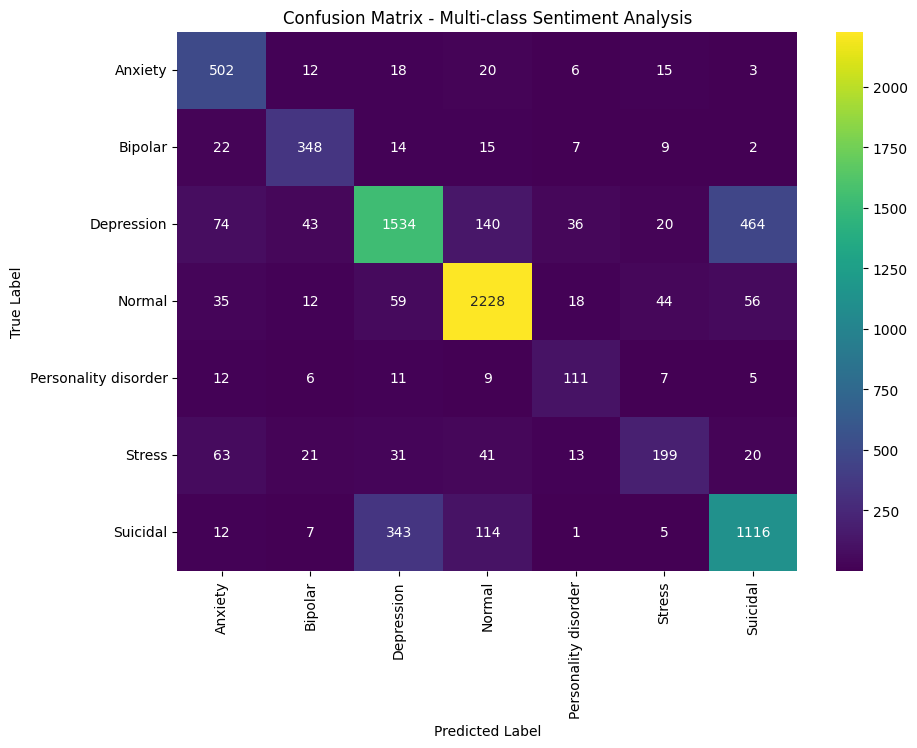

In [22]:
# Define Class Names as per Label Encoding
class_names = list(label_encoder.classes_)
print(class_names)

# Compute Confusion Matrix
con_matrix = confusion_matrix(test_actual, test_pred)

# Plot the Confusion Matrix
plt.figure(figsize = (10,7))
sns.heatmap(con_matrix,
           annot = True,
           fmt = 'd',
           cmap = 'viridis',
           xticklabels = class_names,
           yticklabels = class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Multi-class Sentiment Analysis")
plt.show()

### Post Analysis

In [31]:
# Extracting only the rows belonging to the test set
test_df = df.loc[X_test.index].copy()
test_df['predicted'] = test_pred

# Add back the status labels
label_map = dict(zip(df['label_encoded'], df['status']))
test_df['predicted_status'] = test_df['predicted'].map(label_map)

# Create columns with correct / incorrect classification
test_df['is_correct'] = test_df['label_encoded'] == test_df['predicted']

# Create dataframe for both correct and incorrect classification
correct_df = test_df[test_df['is_correct'] == True]
correct_df = correct_df[['unique_id', 'statement', 'status', 'predicted_status']]
wrong_df = test_df[test_df['is_correct'] == False]
wrong_df = wrong_df[['unique_id', 'statement', 'status', 'predicted_status']]

print("Correct Predictions:", correct_df.shape[0])
print("Wrong Predictions:", wrong_df.shape[0])

Correct Predictions: 6038
Wrong Predictions: 1865


#### **Misclassification by the Model**

In [33]:
# Number of text
n = 5

for idx, row in wrong_df.head(n).iterrows():
    print("="*80)

    print(f"Actual Status: {row['status']}")
    print(f"Predicted Status: {row['predicted_status']}")
    print("\nOriginal Statement:")
    print(row['statement'])

    print("="*80, "\n")

Actual Status: Depression
Predicted Status: Suicidal

Original Statement:
i m a high school student f and i m not living in a country which speaks english so i m sorry if i m making grammatical mistake i m so exhausted i have did because of the s xual a ault i went thru a a child i can t deal with all these flashback and i have exam responsibility i can t even get out of bed but i have to study for exam i don t even know what i want in the future i don t want a future at this point i can t do this anymore so i decided to end it all tonight goodbye everyone

Actual Status: Suicidal
Predicted Status: Depression

Original Statement:
Everywhere I look, there are unreachable standards and expectations. Even the slightest mistake is picked up and shown as proof of failure. Why? Does it make people feel good to be above others? And how do some pass without even the slightest setback? Why am I so sensitive? This is only making me look like a fool in front of others. Why is everyone so judgemen

#### **Correct Classification by the Model**

In [34]:
# Number of text
n = 5

for idx, row in correct_df.head(n).iterrows():
    print("="*80)

    print(f"Actual Status: {row['status']}")
    print(f"Predicted Status: {row['predicted_status']}")
    print("\nOriginal Statement:")
    print(row['statement'])

    print("="*80, "\n")

Actual Status: Anxiety
Predicted Status: Anxiety

Original Statement:
I feel a colon cancer meltdown coming on I probably wouldn’t be worrying so much about colon cancer if I hadn’t spent nearly 24 years of my life being fed ultra processed foods and then going on to cook ultra processed foods for myself. I wish I was more self informed about how bad this food was for me. 

I’m just now starting to figure out what’s good for my colon even though I thought I was doing things right (eating frozen vegan patties which may be even WORSE now that I think about it. I was worried about processed MEAT only and not processed meals in general).

I’ve had hemorrhoid symptoms lasting over 2 months now (itching and bright red spots). Bowel habits constantly change. Lot of gas, bloating, and nausea. Feeling hungry more than usual. I had diarrhea for the first time in a month and a half last weekend, no bowel movements at all for almost 4 days. 

TL;DR I’m nearly 24 years old and have eaten processed 